# Prática 6 - Experimentos - Parte I

#Nome: Ricardo França Fernandes do Vale     No. USP: 9293477

Nesta prática, o foco se dará na modelagem de experimentos para a base de dados, através de algoritmos de classificação, regressão ou agrupamento. Ou seja, a intenção é observar o comportamento do conjunto de dados diante do cenário e modificações a serem feitas no mesmo para que a aplicação do algoritmo retorne o menos erro possível, ou seja, a maior acurácia (de acerto nas predições).


## Dataset - Breast Cancer

Como o objetivo da prática é realizar uma modelagem de avaliação, o dataset de interesse foi modificado para um dataset com classes discretas: o dataset Breast Cancer, que, diante de alguns fatores biológicos (atributos) tem como alvo classificar a amostra como tumor benigno ou maligno. Primeiramente, será carregado o dataset:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
data = pd.DataFrame(data=np.c_[data['data'], data['target']], 
                          columns=np.r_[data['feature_names'], ['target']])
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


### 1. Dada a introdução acima, já definimos que o tipo do problema é classificação. Defina quais os atributos você utilizará, e a medida de avaliação você acha adequada e explique o porquê dessas escolhas

Dada a análise da prática anterior diante dos atributos analisados, serão escolhidos apenas atributos relativos às médias e à média de piores valores. Os critérios para escolher tais valores se basearão nos histogramas de dados dos atributos. Serão descartados atributos com obliquidade positiva (dados não simétricos) e priorizados os dados que se assemelhem à distribuição normal (devido ao fato de ser mais fácil aplicar operações estatísticas neles). Abaixo serão exibidos os histogramas.

Histograma das features - médias


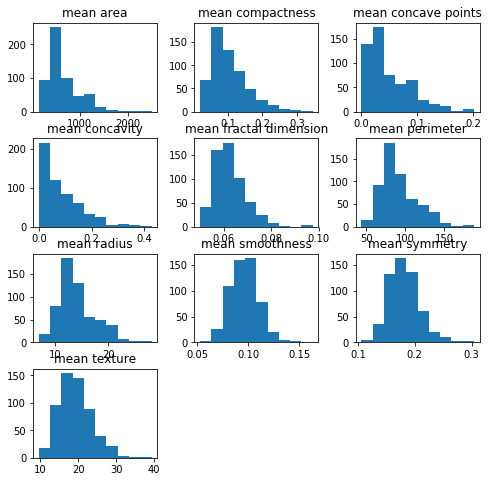

Histograma das features - médias das três piores medições


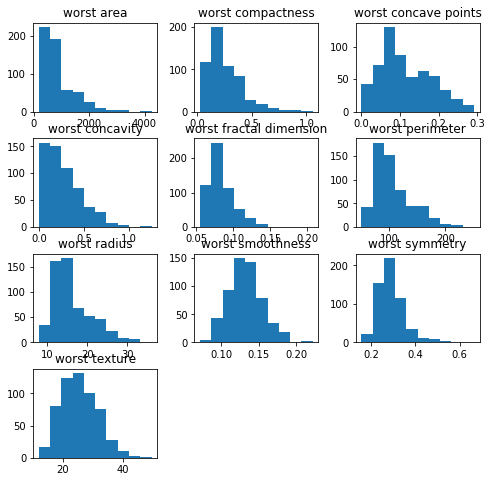

In [3]:
print('Histograma das features - médias')
data.iloc[:,0:10].hist(figsize=(8,8),grid=False)
plt.show()
print('Histograma das features - médias das três piores medições')
data.iloc[:,20:30].hist(figsize=(8,8),grid=False)
plt.show()


Sendo assim, os atributos escolhidos para a aplicação do modelo de classificação são:
* mean smoothness
* mean symmetry
* worst smoothness
* worst texture

Quanto à medida de avaliação, dado que é um problema binário de classificação (apenas duas classes rotulando os registros no conjunto de dados), a classe positiva (p) será a classe 0 (que indica tumores malignos), caso em que o câncer deve ser tratado mais intensamente e a classe negativa (n) será a classe 1 (que indica tumores benignos. A hipótese, portanto, é centrada em verificar quais objetos das amostras estão doentes.

O erro mais perigoso, levando para o contexto dos dados, é classificar um tumor maligno como benigno (a recíproca também é danosa na prática), será usado o **erro falso negativo**, para capturar os registros classificados como **tumores benignos (n, ou 1)** que, no entanto, são **tumores malignos (p, ou 0)**.

### 2. Execução da função de classificação

Abaixo serão salvos o novo conjunto de dados e a função de classificação

In [4]:
bc = data[['mean smoothness','mean symmetry', 'worst smoothness','worst texture','target']].copy()
bc.head()

,mean smoothness,mean symmetry,worst smoothness,worst texture,target
0,0.11840,0.2419,0.1622,17.33,0.0
1,0.08474,0.1812,0.1238,23.41,0.0
2,0.10960,0.2069,0.1444,25.53,0.0
3,0.14250,0.2597,0.2098,26.50,0.0
4,0.10030,0.1809,0.1374,16.67,0.0


In [35]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
    
    if not plot:
        return {'y_test': y_test, 'y_pred':y_pred}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}



Sendo assim, será obtido o erro da classificação para os tipos diferentes de classificadores pode ser encontrado abaixo:

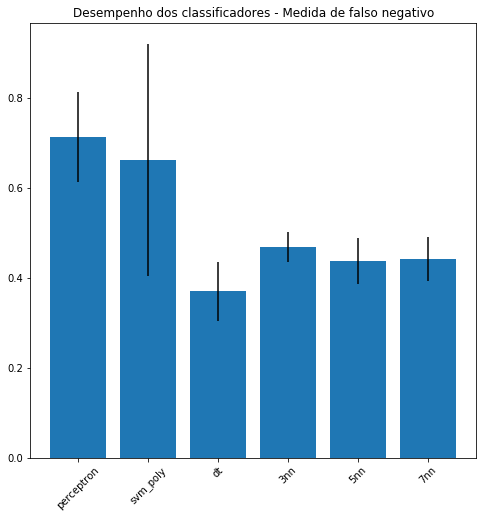

In [19]:
def pen_falso_negativo(y_true, y_pred):
    import numpy as np
    count = 0
    for i,j in enumerate(y_pred):
        if y_true[i] == 0 and j == 1:
            count += 2
        elif y_true[i] == 1 and j == 0:
            count += 1
    return count/len(y_true)

# aplicação da classificação
clf_custom = classificacao(bc, [0,1,2,3], 4, pen_falso_negativo, 'Medida de falso negativo')

Conforme o gráfico acima, é possível perceber um erro menor por parte das árvores de decisão e dos algoritmos de vizinhos mais próximos. Porém, pelo gráfico é possível perceber que, ao realizar um benchmark entre as árvores de decisão e os k vizinhos mais próximos, a acurácia maior e o menor erro estão presentes no **3nn**, portanto, **os algoritmos de k vizinhos mais próximos possuem desempenho melhor**.

### 3 - Estimações de desempenho e procedimentos de amostragem

Escolhido o algoritmo de k vizinhos mais próximos, mais precisamente o **3nn**, serão utilizados os seguintes estimadores de desempenho para o 5nn no conjunto de dados:
- 10-fold Cross Validation;
- Leave-one-out;
- Boostrap (1000 amostras de boostrap).

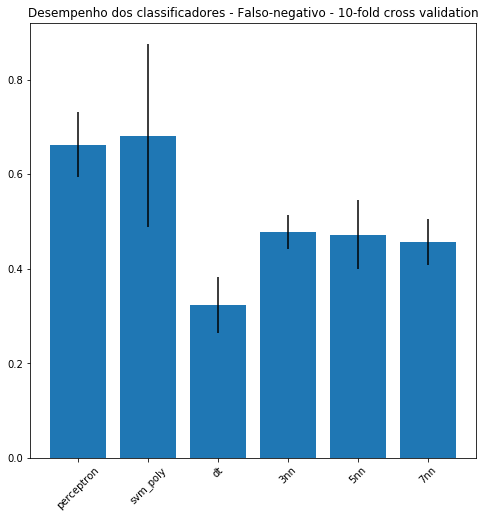

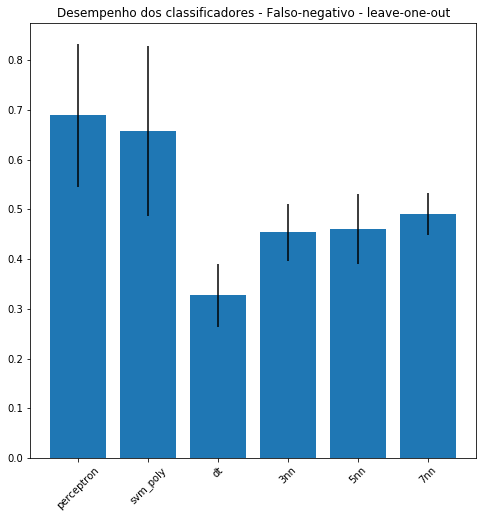

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

# 10-fold-CV
clf_10_fold_cv = classificacao(bc, [0,1,2,3], 4, pen_falso_negativo, 'Falso-negativo - 10-fold cross validation', 
                               folds=10)

# Leave-one-out
clf_loo_acc = classificacao(bc, [0,1,2,3], 4, pen_falso_negativo, 'Falso-negativo - leave-one-out',
                            folds=bc.shape[0])


In [21]:
# Algoritmo de classificação com bootstrap


from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
def classificacao_bootstrap(bootstrap_dts, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(bootstrap_dts[0]), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(bootstrap_dts[0])*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')

    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']


    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for dt_boot in bootstrap_dts:

            # separa 80% para treino e 20% para teste
            test = dt_boot.sample(n=int(N_samples*0.2), replace=False)
            train = dt_boot.iloc[-test.index]

            # faz o treino do modelo
            clf = c.fit(X=train.iloc[:, columns], y=train.iloc[:, target])

            # valores predito pelo classificador
            y_pred = clf.predict(test.iloc[:, columns])
            # rótulos verdadeiros convertidos para array
            y_test = np.array(test.iloc[:, target])

            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )

    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


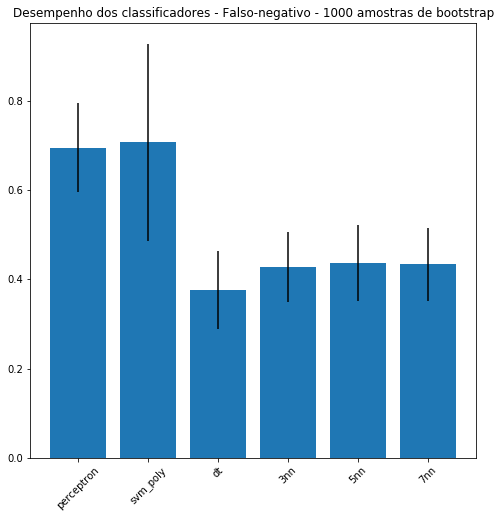

In [22]:
# criando amostras de bootstrap
dataset = bc.copy()
N_btp_samples = 1000
N_samples = dataset.shape[0]
bootstrap_dts = [dataset.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]

# cada amostra de bootstrap tem o mesmo número de exemplos do dataset original
clf_boot_acc = classificacao_bootstrap(bootstrap_dts, [0,1,2,3], 4, 
                                  pen_falso_negativo, 'Falso-negativo - 1000 amostras de bootstrap')


O próximo passo é realizar a classificação em conjuntos de dados com subamostragem e superamostragem. Reaproveitando o procedimento da prática anterior, a subamostragem ocorrerá com 200 exemplos/classe e a superamostragem com 400 exemplos/classe.

Subamostragem


Fixando o número de exemplos por classe em 200
        mean smoothness
target                 
0.0                 200
1.0                 200



Superamostragem


Fixando o número de exemplos por classe em 400
        mean smoothness
target                 
0.0                 400
1.0                 400


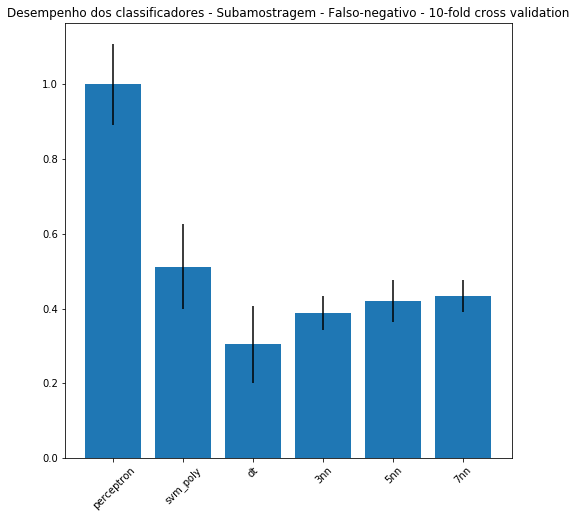

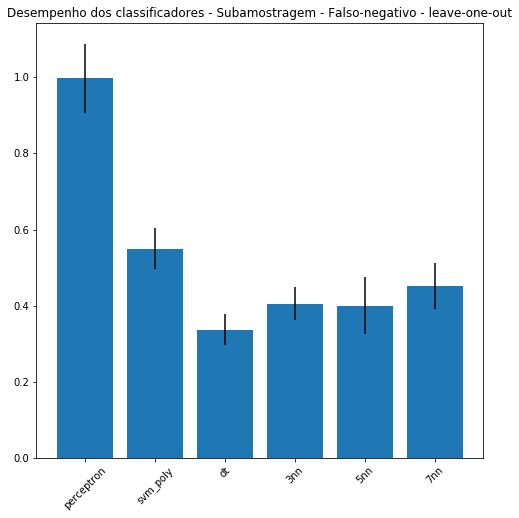

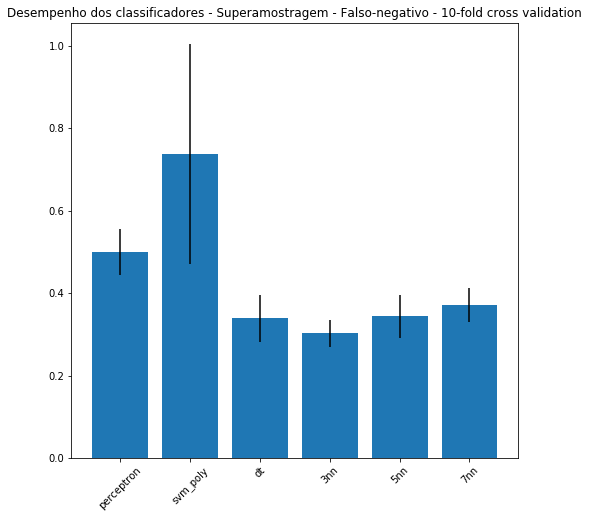

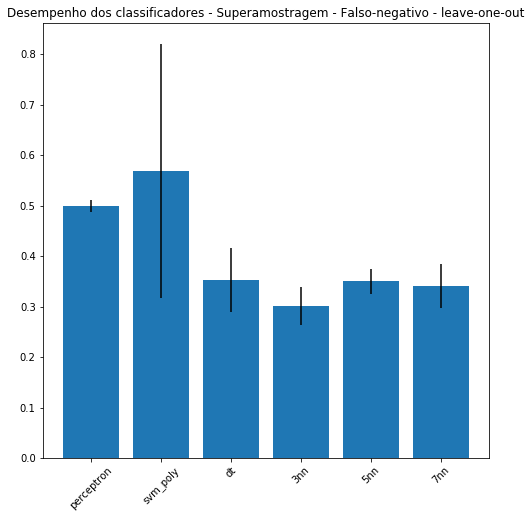

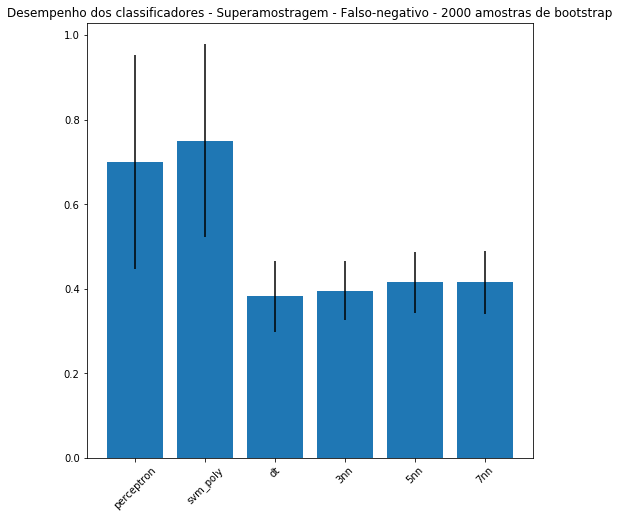

In [28]:
# Subamostragem
print('Subamostragem')
data2 = [bc.loc[bc.target == c, :].sample(n=200, replace=True) for c in bc.target.unique()]
print('\n\nFixando o número de exemplos por classe em 200')
data2 = pd.concat(data2)
print(data2.iloc[:, [0,-1]].groupby('target').count())
print('\n\n')
# Superamostragem
print('Superamostragem')
data3 = [bc.loc[bc.target == c, :].sample(n=400, replace=True) for c in bc.target.unique()]
print('\n\nFixando o número de exemplos por classe em 400')
data3 = pd.concat(data3)
print(data3.iloc[:, [0,-1]].groupby('target').count())


# classificação - subamostragem
# 10-fold-CV
clf_10_fold_cv_sub = classificacao(data2, [0,1,2,3], 4, pen_falso_negativo, 'Subamostragem - Falso-negativo - 10-fold cross validation', 
                               folds=10)

# Leave-one-out
clf_loo_acc_sub = classificacao(data2, [0,1,2,3], 4, pen_falso_negativo, 'Subamostragem - Falso-negativo - leave-one-out',
                            folds=data2.shape[0])

# classificação - superamostragem
# 10-fold-CV
clf_10_fold_cv_super = classificacao(data3, [0,1,2,3], 4, pen_falso_negativo, 'Superamostragem - Falso-negativo - 10-fold cross validation', 
                               folds=10)

# Leave-one-out
clf_loo_acc_super = classificacao(data3, [0,1,2,3], 4, pen_falso_negativo, 'Superamostragem - Falso-negativo - leave-one-out',
                            folds=data3.shape[0])

# Bootstrap (2000 amostras)
dataset2 = data3.copy()
N_btp_samples = 2000
N_samples = dataset2.shape[0]
bootstrap_dts = [dataset2.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]

clf_boot_acc_super = classificacao_bootstrap(bootstrap_dts, [0,1,2,3], 4, 
                                  pen_falso_negativo, 'Superamostragem - Falso-negativo - 2000 amostras de bootstrap')




Não foi possível realizar o bootstrap com 200 amostras para o exemplo da subamostragem devido a um erro de acesso a indexação incorreto. Portanto, foi a única classificação não feita diante das sugestões.

### 4 - Após calcular as medidas de avaliação da matriz de confusão, como escolher o melhor classificador?

Abaixo, serão calculadas as medidas da matriz de confusão pela estimativa de desempenho 10-fold cross validation:
- Taxa de falso positivo (TFP)
- Taxa de falso negativo (TFN)
- Taxa de verdadeiro positivo (TVP)
- Taxa de verdadeiro negativo (TVN)

In [45]:
clf_10_fold_cv = classificacao(bc, [0,1,2,3], 4, pen_falso_negativo, 'Falso-negativo - 10-fold cross validation', 
                               folds=10, plot=False)

from sklearn.metrics import confusion_matrix
vp, fn, fp, vn = confusion_matrix(clf_10_fold_cv['y_test'], clf_10_fold_cv['y_pred']).ravel()

print('Dada a configuração da matriz: ')
print('|----------|')
print('| VP\tFN |')
print('| FP\tVN |')
print('|----------|\n\n')
print('Medida de desempenho - 10-fold cross validation')
print('Taxa de falso positivo',fp/float(fp+vn))
print('Taxa de falso negativo',fn/float(fn+vp))
print('Taxa de verdadeiro positivo', vp/float(vp+fn))
print('Taxa de verdadeiro negativo', vn/float(vn+fp))

Dada a configuração da matriz: 
|----------|
| VP	FN |
| FP	VN |
|----------|


Medida de desempenho - 10-fold cross validation
Taxa de falso positivo 0.19696969696969696
Taxa de falso negativo 0.46808510638297873
Taxa de verdadeiro positivo 0.5319148936170213
Taxa de verdadeiro negativo 0.803030303030303


**Conclusão:** A escolha do classificador e da estimativa depende muito do problema que está sendo estudado. Conforme a matriz de confusão exibe acima, a taxa de falso negativo é próxima à taxa de verdadeiro negativo, o que indica um grave problema ao aplicarmos os conceitos aos dados que estão sendo estudados, que, no caso, indicaria pacientes cujo tumor maligno é identificado como benigno. Portanto, é possível inferir que o modelo de classificação não foi adequado e que o resultado da estimativa não influencia muito nisso a partir do momento em que o modelo de classificação não é pertinente.

Portanto, deve-se estudar o espaço de dados para identificar qual viés de qual classificador irá fornecer uma predição mais adequada para o problema (não necessariamente um classificador que acerte todas as inferências, mas sim, um que evite ao máximo erros de falso negativo ou de falso postivo, dependendo do problema) e, ao ser escolhido o modelo, deve-se realizar uma estimativa de erro que verifique de maneira correta a eficiência do classificador.